# Magic command for Notebook

# Data Generation

1.Generate data: 2.Three clusters 3.True centroids (4,0), (6,6), (0,4)

In [1]:
%matplotlib inline
import numpy as np
import pylab 
size1 = size2 = size3 = 10000
samples1 = np.random.multivariate_normal([4, 0], [[1, 0],[0, 1]], size1)
data = samples1
samples2 = np.random.multivariate_normal([6, 6], [[1, 0],[0, 1]], size2)
data = np.append(data,samples2, axis=0)
samples3 = np.random.multivariate_normal([0, 4], [[1, 0],[0, 1]], size3)
data = np.append(data,samples3, axis=0)
# Randomlize data
data = data[np.random.permutation(size1+size2+size3),]
np.savetxt('Kmeandata.csv',data,delimiter = ",")


In [66]:
data.shape

(30000, 2)

###Using the kmeans|| Algorithm

**Plan**
1. Sample one point c1 uniformly from the dataset X. The set C of candidate centroids has its first member, c1. 
2. Compute `psi(c1)` = sum of squared distances from c1 to all points in dataset
3. Calculate log(psi(c1)) to determine number of times NN to perform Step 4. 
4. for i in range(NN): sample x in dataset with probability:

L * d<sup>2</sup>(x, C) / phi(X, C)

where:
- L is an oversampling factor (we will use 2k, or 6)
- d<sup>2</sup>(x, C) is the squared distance of x from the set of centroids C
- phi(X, C) is the squared distance of X from C 

5. Add the points discovered in Step 4 to the set of candidate centroids C. 
6. For each ci in C, let wi be the number of points in X closest to ci. 
7. The cardinality of C is typically > k. Use kmeans on C to find k candidate centroids. 

####Steps 1, 2, 3:

In [69]:
#Calculate first value of Psi: 
a = np.random.choice(30000)
c1 = data[a,:2]
print "Step 1: c1 = ", c1
diff = data - c1
#print diff[:3,:3]
nn = diff*diff
#print nn[:3, :3]
tot = sum(nn)[0] + sum(nn)[1]
NN = int(np.log(tot))

print "Step 2: psi(c1) = ", tot
print "Step 3: log(psi(c1)) = ", np.log(tot)


Step 1: c1 =  [ 5.56537424  7.74426265]
Step 2: psi(c1) =  1166888.00709
Step 3: log(psi(c1)) =  13.9698509402


####Step 4
Supporting function that computes the sampling. 

In [70]:
from collections import namedtuple
from random import random, choice
from copy import copy

def kpp_ll(points, cluster_centers, ell): #ell is oversampling factor
    """
    
    """
    cluster_centers[0] = copy(choice(points))
    d = [0.0 for _ in xrange(len(points))]
 
    for i in xrange(1, len(cluster_centers)):
        sum = 0
        for j, p in enumerate(points):
            d[j] = nearest_cluster_center(p, cluster_centers[:i])[1]
            sum += d[j]
 
        sum *= ell*random()
 """
        for j, di in enumerate(d): #complicated because now have to go in chunks of ell
            
            sum -= ell*di
            if sum > 0:
                continue
            cluster_centers[i] = copy(points[j])
            break
 """
        
            
        for j in range(len(points)/ell):
            ddi = 0
            for ii in range(j*ell, (j+1)*ell):
                ddi += d[ii] #sum of ell chunks of d
            sum -= ddi
            if sum > 0:
                continue
            cluster_centers[i] = copy(points[j])
        
 
    for p in points:
        p.group = nearest_cluster_center(p, cluster_centers)[0]
        


SyntaxError: invalid syntax (<ipython-input-70-aae1f0bf6743>, line 21)

In [56]:
b = np.random.choice(30000)
cc = data[a,:2] - data[b,:2]
csq = cc*cc
pcc = sum(csq)/tot
print "%.9f\t%i" % (pcc, b)
print (pcc - 1.0/30000.0)*10000

0.000050557	20052
0.172236453782


In [43]:
b

12994

In [40]:
1.0/30000.0

3.3333333333333335e-05

In [65]:
u = np.random.choice(30000)
u = u/30000.0
u

0.3497

In [60]:
data[:2,:2]

array([[ 1.27670469,  5.20949054],
       [ 5.17469754,  6.82893284]])

# Data Visualiazation

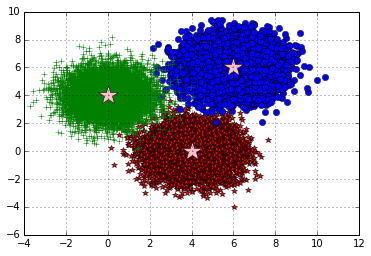

In [2]:
pylab.plot(samples1[:, 0], samples1[:, 1],'*', color = 'red')
pylab.plot(samples2[:, 0], samples2[:, 1],'o',color = 'blue')
pylab.plot(samples3[:, 0], samples3[:, 1],'+',color = 'green')
pylab.plot((4,6,0),(0,6,4), '*', color = 'pink', markersize=20) 
pylab.grid()
pylab.show()

# MrJob class for Kmeans

### If you want to change the code, please edit Kmeans.py directly

In [1]:
%%writefile Kmeans.py
from numpy import argmin, array, random
from mrjob.job import MRJob
from mrjob.step import MRJobStep
from itertools import chain

#Calculate find the nearest centroid for data point 
def MinDist(datapoint, centroid_points):
    datapoint = array(datapoint)
    centroid_points = array(centroid_points)
    diff = datapoint - centroid_points 
    diffsq = diff*diff
    # Get the nearest centroid for each instance
    minidx = argmin(list(diffsq.sum(axis = 1)))
    return minidx

#Check whether centroids converge
def stop_criterion(centroid_points_old, centroid_points_new,T):
    oldvalue = list(chain(*centroid_points_old))
    newvalue = list(chain(*centroid_points_new))
    Diff = [abs(x-y) for x, y in zip(oldvalue, newvalue)]
    Flag = True
    for i in Diff:
        if(i>T):
            Flag = False
            break
    return Flag

class MRKmeans(MRJob):
    centroid_points=[]
    k=3    
    def steps(self):
        return [
            MRJobStep(mapper_init = self.mapper_init, mapper=self.mapper,combiner = self.combiner,reducer=self.reducer)
               ]
    #load centroids info from file
    def mapper_init(self):
        self.centroid_points = [map(float,s.split('\n')[0].split(',')) for s in open("Centroids.txt").readlines()]
        open('Centroids.txt', 'w').close()
    #load data and output the nearest centroid index and data point 
    def mapper(self, _, line):
        D = (map(float,line.split(',')))
        yield int(MinDist(D,self.centroid_points)), (D[0],D[1],1)
    #Combine sum of data points locally
    def combiner(self, idx, inputdata):
        sumx = sumy = num = 0
        for x,y,n in inputdata:
            num = num + n
            sumx = sumx + x
            sumy = sumy + y
        yield idx,(sumx,sumy,num)
    #Aggregate sum for each cluster and then calculate the new centroids
    def reducer(self, idx, inputdata): 
        centroids = []
        num = [0]*self.k 
        for i in range(self.k):
            centroids.append([0,0])
        for x, y, n in inputdata:
            num[idx] = num[idx] + n
            centroids[idx][0] = centroids[idx][0] + x
            centroids[idx][1] = centroids[idx][1] + y
        centroids[idx][0] = centroids[idx][0]/num[idx]
        centroids[idx][1] = centroids[idx][1]/num[idx]
        with open('Centroids.txt', 'a') as f:
            f.writelines(str(centroids[idx][0]) + ',' + str(centroids[idx][1]) + '\n')
        yield idx,(centroids[idx][0],centroids[idx][1])
      
if __name__ == '__main__':
    MRKmeans.run()

Writing Kmeans.py


# Driver:

Generate random initial centroids

New Centroids = initial centroids

While(1)：
+ Cacluate new centroids
+ stop if new centroids close to old centroids
+ Updates centroids 

In [5]:
from numpy import random
from Kmeans import MRKmeans, stop_criterion
mr_job = MRKmeans(args=['Kmeandata.csv'])

#Geneate initial centroids
centroid_points = []
k = 3
for i in range(k):
    centroid_points.append([random.uniform(-3,3),random.uniform(-3,3)])
with open('Centroids.txt', 'w+') as f:
        f.writelines(','.join(str(j) for j in i) + '\n' for i in centroid_points)

# Update centroids iteratively
i = 0
while(1):
    # save previous centoids to check convergency
    centroid_points_old = centroid_points[:]
    print "iteration"+str(i)+":"
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            key,value =  mr_job.parse_output_line(line)
            print key, value
            centroid_points[key] = value
    print "\n"
    i = i + 1
    if(stop_criterion(centroid_points_old,centroid_points,0.01)):
        break
print "Centroids\n"
print centroid_points

iteration0:


IOError: [Errno 2] No such file or directory: 'Centroids.txt'

In [7]:
!ls


Kmeans.py


In [8]:
!pwd


/private/var/folders/j4/95k348x940xcz40fkdmgy_n40000gn/T/Kmeans.jshanahan.20160204.044048.533821/job_local_dir/0/mapper/0
